# Imports

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

import torch
from torch import nn, optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable

from PIL import Image

from tqdm import tqdm_notebook as tqdm

## Variable definitions

In [2]:
batch_size = 32
lr = 0.001
epochs = 20
latent_dim = 32
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

labels = pd.read_csv('labels.csv')### Custom dataset

In [3]:
labels = pd.read_csv('labels.csv')
labels.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


## Dataset definition

In [4]:
class DogDataset(Dataset):
    def __init__(self, img_dir, labels, transform1=None, transform2=None):
    
        self.img_dir = img_dir
        self.img_names = os.listdir(img_dir)
        self.transform1 = transform1
        self.transform2 = transform2
        self.labels = labels
        
        self.imgs = []
        for img_name in self.img_names:
            img = Image.open(os.path.join(img_dir, img_name))
            
            if self.transform1 is not None:
                img = self.transform1(img)
                
            self.imgs.append(img)

    def __getitem__(self, index):
        img = self.imgs[index]
        
        if self.transform2 is not None:
            img = self.transform2(img)
            label = self.labels.iloc[index, 1]
        return (img, label)

    def __len__(self):
        return len(self.imgs)

In [5]:
transform1 = transforms.Compose([transforms.Resize(64),
                                transforms.CenterCrop(64)])

random_transforms = [transforms.RandomRotation(degrees=10)]
transform2 = transforms.Compose([transforms.RandomHorizontalFlip(p=0.5),
                                 transforms.RandomApply(random_transforms, p=0.3), 
                                 transforms.ToTensor(),
                                 transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
                                 
train_dataset = DogDataset(img_dir='data/train',
                           labels=labels,
                           transform1=transform1,
                           transform2=transform2)

train_loader = DataLoader(dataset=train_dataset,
                          batch_size=batch_size,
                          shuffle=True)

### Examples of data

entrei
('sussex_spaniel', 'kelpie', 'appenzeller', 'samoyed', 'african_hunting_dog', 'wire-haired_fox_terrier', 'irish_terrier', 'standard_schnauzer', 'irish_setter', 'clumber', 'border_collie', 'west_highland_white_terrier', 'dingo', 'bouvier_des_flandres', 'boston_bull', 'english_setter', 'mexican_hairless', 'norwegian_elkhound', 'doberman', 'blenheim_spaniel', 'toy_terrier', 'brittany_spaniel', 'samoyed', 'bedlington_terrier', 'malamute', 'shih-tzu', 'english_springer', 'irish_wolfhound', 'cairn', 'walker_hound', 'yorkshire_terrier', 'kelpie')


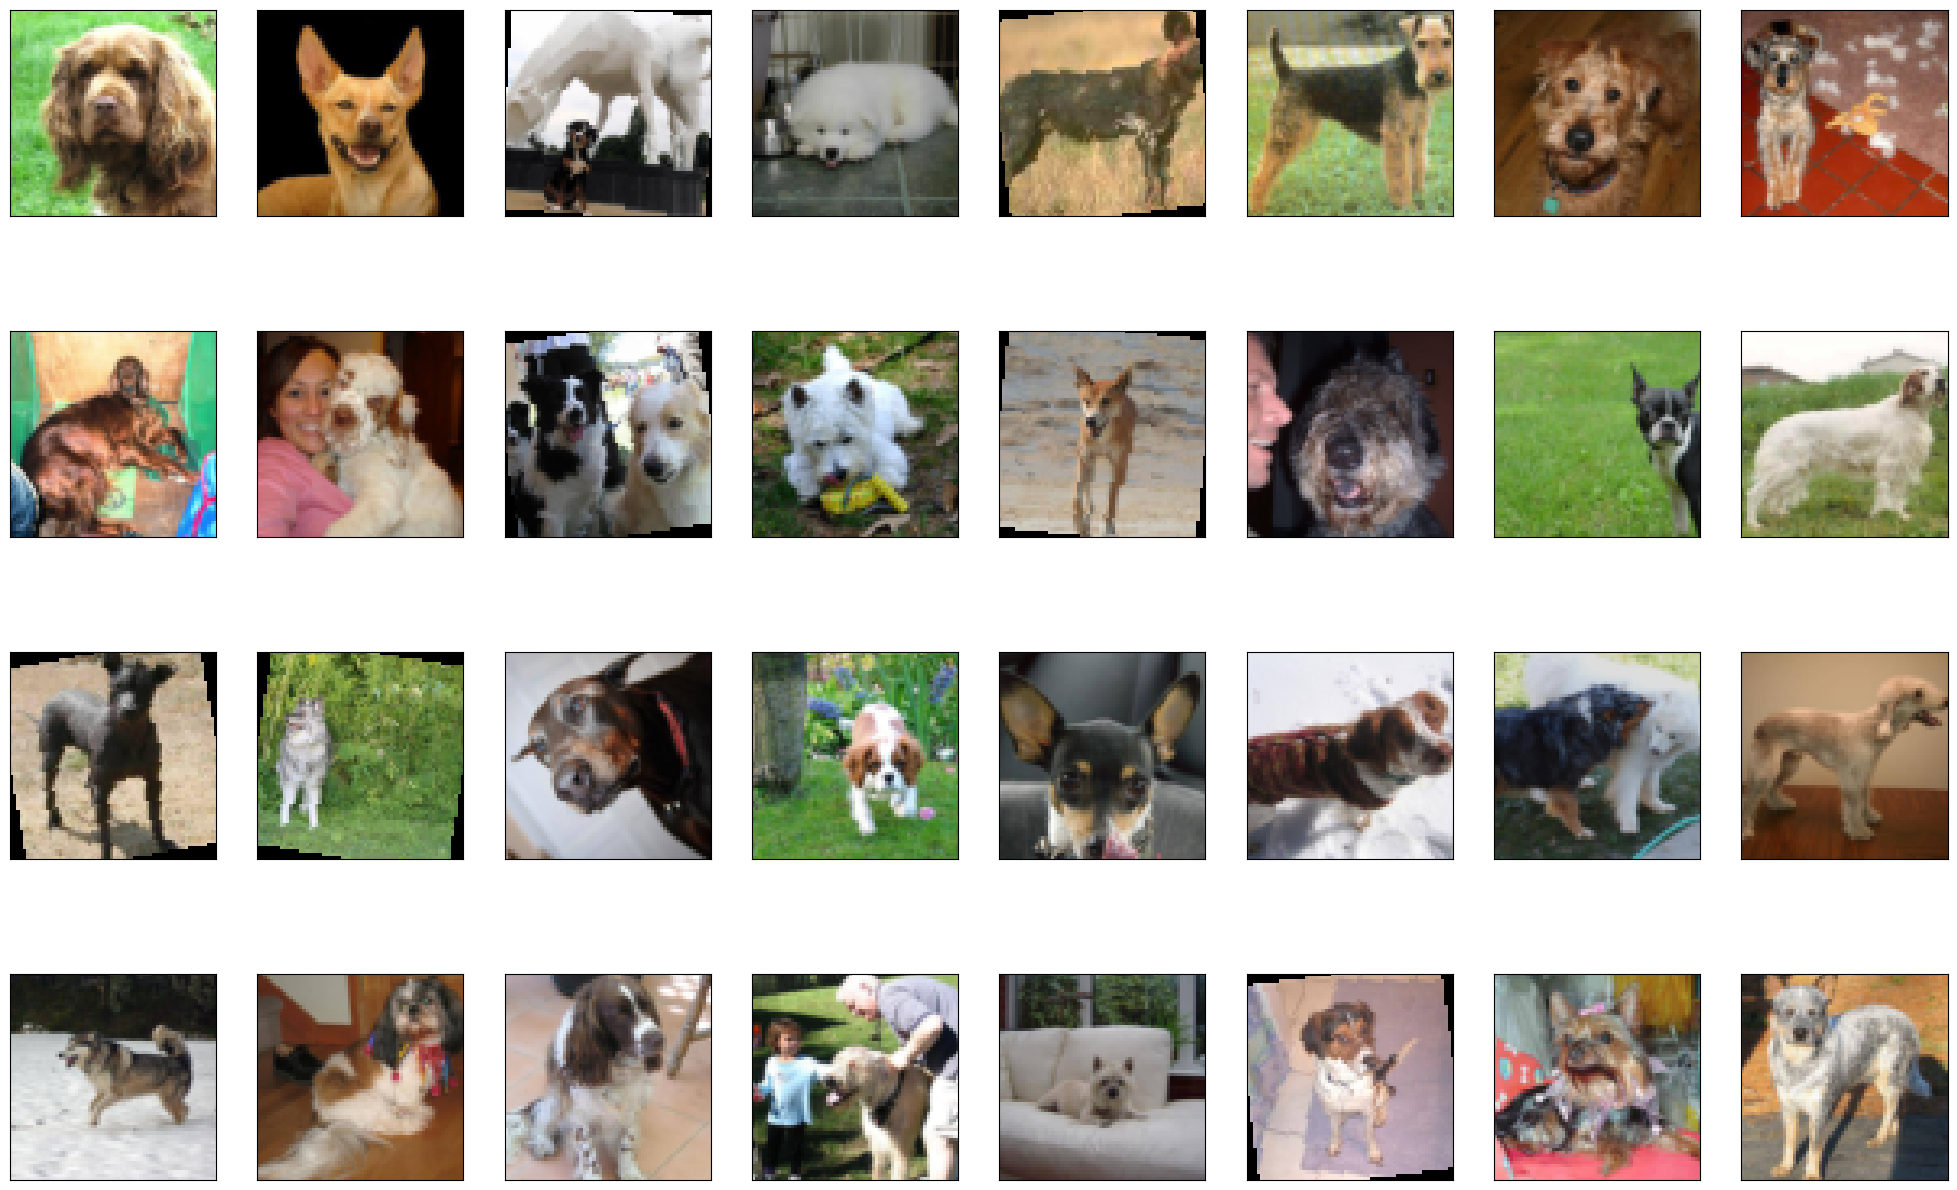

In [6]:
for i, (x, y) in enumerate(train_loader):
        print('entrei')
        #print(i)
        #print(x)
        print(y)
        fig = plt.figure(figsize=(25, 16))
        for ii, img in enumerate(x):
            ax = fig.add_subplot(4, 8, ii + 1, xticks=[], yticks=[])

            img = img.numpy().transpose(1, 2, 0)
            plt.imshow((img+1)/2)
        break

## VAE Model
The code below is based on https://github.com/atinghosh/VAE-pytorch

In [7]:
class VAE(nn.Module):
    def __init__(self, latent_dim=128, no_of_sample=10, batch_size=32, channels=3):
        super(VAE, self).__init__()
        
        self.no_of_sample = no_of_sample
        self.batch_size = batch_size
        self.channels = channels
        self.latent_dim = latent_dim
        
        
        # Encoder
        def convlayer_enc(n_input, n_output, k_size=4, stride=2, padding=1, bn=False):
            block = [nn.Conv2d(n_input, n_output, kernel_size=k_size, stride=stride, padding=padding, bias=False)]
            if bn:
                block.append(nn.BatchNorm2d(n_output))
            block.append(nn.LeakyReLU(0.2, inplace=True))
            return block
        
        self.encoder = nn.Sequential(
            *convlayer_enc(self.channels, 64, 4, 2, 2),               # (64, 32, 32)
            *convlayer_enc(64, 128, 4, 2, 2),                         # (128, 16, 16)
            *convlayer_enc(128, 256, 4, 2, 2, bn=True),               # (256, 8, 8)
            *convlayer_enc(256, 512, 4, 2, 2, bn=True),               # (512, 4, 4)
            nn.Conv2d(512, self.latent_dim*2, 4, 1, 1, bias=False),   # (latent_dim*2, 4, 4)
            nn.LeakyReLU(0.2, inplace=True)
        )
        
        
        # Decoder
        def convlayer_dec(n_input, n_output, k_size=4, stride=2, padding=0):
            block = [
                nn.ConvTranspose2d(n_input, n_output, kernel_size=k_size, stride=stride, padding=padding, bias=False),
                nn.BatchNorm2d(n_output),
                nn.ReLU(inplace=True),
            ]
            return block
        
        self.decoder = nn.Sequential(
            *convlayer_dec(self.latent_dim, 512, 4, 2, 1),           # (512, 8, 8)
            *convlayer_dec(512, 256, 4, 2, 1),                       # (256, 16, 16)
            *convlayer_dec(256, 128, 4, 2, 1),                       # (128, 32, 32)
            *convlayer_dec(128, 64, 4, 2, 1),                        # (64, 64, 64)
            nn.ConvTranspose2d(64, self.channels, 3, 1, 1),          # (3, 64, 64)
            nn.Sigmoid()
        )

    def encode(self, x):
        '''return mu_z and logvar_z'''
        x = self.encoder(x)
        return x[:, :self.latent_dim, :, :], x[:, self.latent_dim:, :, :]
    
    def decode(self, z):
        z = self.decoder(z)
        return z.view(-1, 3 * 64 * 64)

    def reparameterize(self, mu, logvar):
        if self.training:
            # multiply log variance with 0.5, then in-place exponent
            # yielding the standard deviation

            sample_z = []
            for _ in range(self.no_of_sample):
                std = logvar.mul(0.5).exp_()
                eps = Variable(std.data.new(std.size()).normal_())
                sample_z.append(eps.mul(std).add_(mu))
            return sample_z
        
        else:
            return mu

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        
        if self.training:
            return [self.decode(z) for z in z], mu, logvar
        else:
            return self.decode(z), mu, logvar

    def loss_function(self, recon_x, x, mu, logvar):

        if self.training:
            BCE = 0
            for recon_x_one in recon_x:
                BCE += F.binary_cross_entropy(recon_x_one, x.view(-1, 3 * 64 * 64))
            BCE /= len(recon_x)
        else:
            BCE = F.binary_cross_entropy(recon_x, x.view(-1, 3 * 64 * 64))

        KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        KLD /= self.batch_size * 3 * 64 * 64

        return BCE + KLD

In [8]:
model = VAE(latent_dim, batch_size=batch_size).to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)

### Image for validation

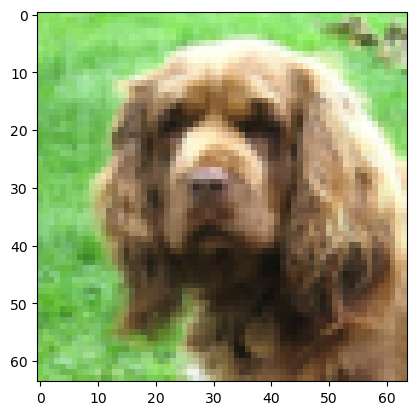

In [9]:
plt.imshow((x[0].numpy().transpose(1, 2, 0)+1)/2)
plt.show()

## Train loop

In [10]:
for epoch in range(1, epochs+1):
    model.train()
    print(f'Epoch {epoch} start')
    
    for batch_idx, data in enumerate(train_loader):
        data = data[0].to(device)
        optimizer.zero_grad()

        recon_batch, mu, logvar = model(data)
        loss = model.loss_function(recon_batch, data, mu, logvar)

        loss.backward()
        optimizer.step()
        
    model.eval()
    recon_img, _, _ = model(x[:1].to(device))
    img = recon_img.view(3, 64, 64).detach().cpu().numpy().transpose(1, 2, 0)
    

Epoch 1 start
Epoch 2 start
Epoch 3 start


KeyboardInterrupt: 

## Check how well VAE reconstruct images

entrei
('toy_poodle', 'clumber', 'collie', 'cocker_spaniel', 'cairn', 'brittany_spaniel', 'keeshond', 'malamute', 'english_foxhound', 'eskimo_dog', 'flat-coated_retriever', 'appenzeller', 'brittany_spaniel', 'dandie_dinmont', 'yorkshire_terrier', 'komondor', 'basset', 'afghan_hound', 'scottish_deerhound', 'collie', 'border_terrier', 'briard', 'samoyed', 'ibizan_hound', 'cocker_spaniel', 'keeshond', 'great_pyrenees', 'sealyham_terrier', 'whippet', 'norwich_terrier', 'chesapeake_bay_retriever', 'malamute')


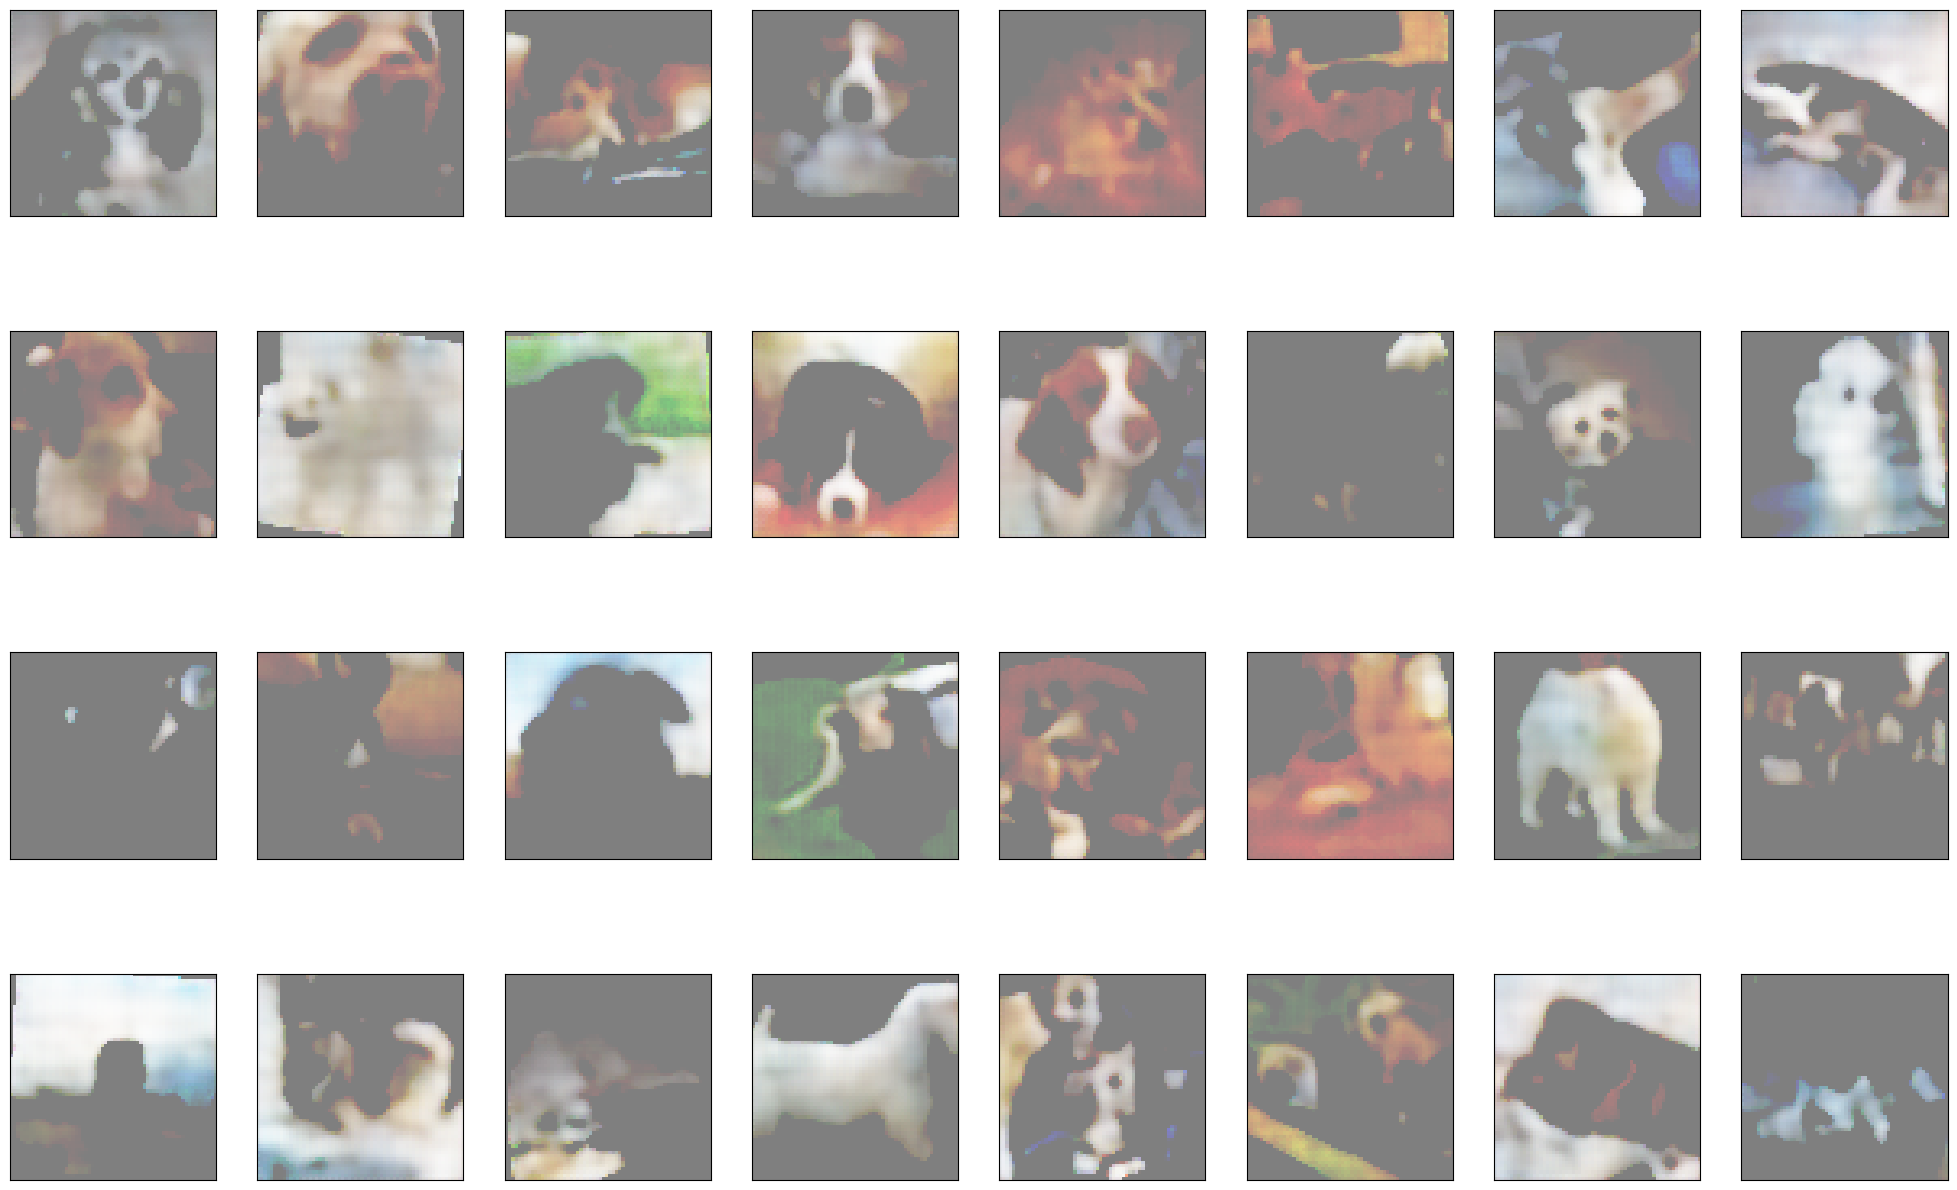

In [35]:
for i, (x, y) in enumerate(train_loader):
reconstructed, mu, _ = model(x.to(device))
reconstructed = reconstructed.view(-1, 3, 64, 64).detach().cpu().numpy().transpose(0, 2, 3, 1)

fig = plt.figure(figsize=(25, 16))
for ii, img in enumerate(reconstructed):
    ax = fig.add_subplot(4, 8, ii + 1, xticks=[], yticks=[])
    plt.imshow((img+1.)/2.)

### resonable results

## mixing races

In [47]:
def dog_breeds_mix(first_dog_idx, second_dog_idx):

    dz = (mu[second_dog_idx] - mu[first_dog_idx]) / 15
    walk = Variable(torch.randn(16, latent_dim, 4, 4)).to(device)
    walk[0] = mu[first_dog_idx]

    for i in range(1, 16):
        walk[i] = walk[i-1] + dz
    walk = model.decoder(walk).detach().cpu().numpy().transpose(0, 2, 3, 1)

    fig = plt.figure(figsize=(25, 16))
    for ii, img in enumerate(walk):
        ax = fig.add_subplot(4, 8, ii + 1, xticks=[], yticks=[])
        plt.imshow((img+1.)/2.)

### Clumber and cocker spaniel mix

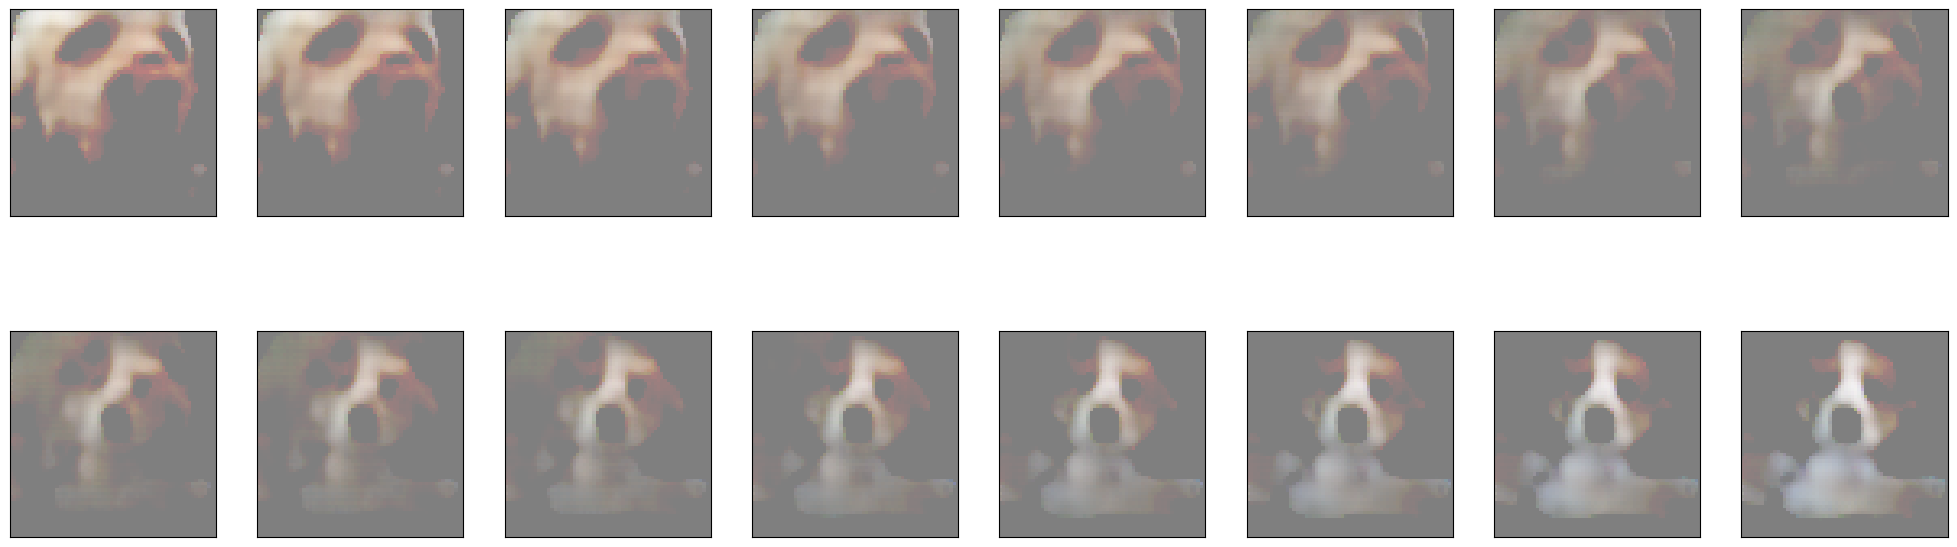

In [48]:
dog_breeds_mix(1, 3)

# brittany_spaniel and yorkshire_terrier mix

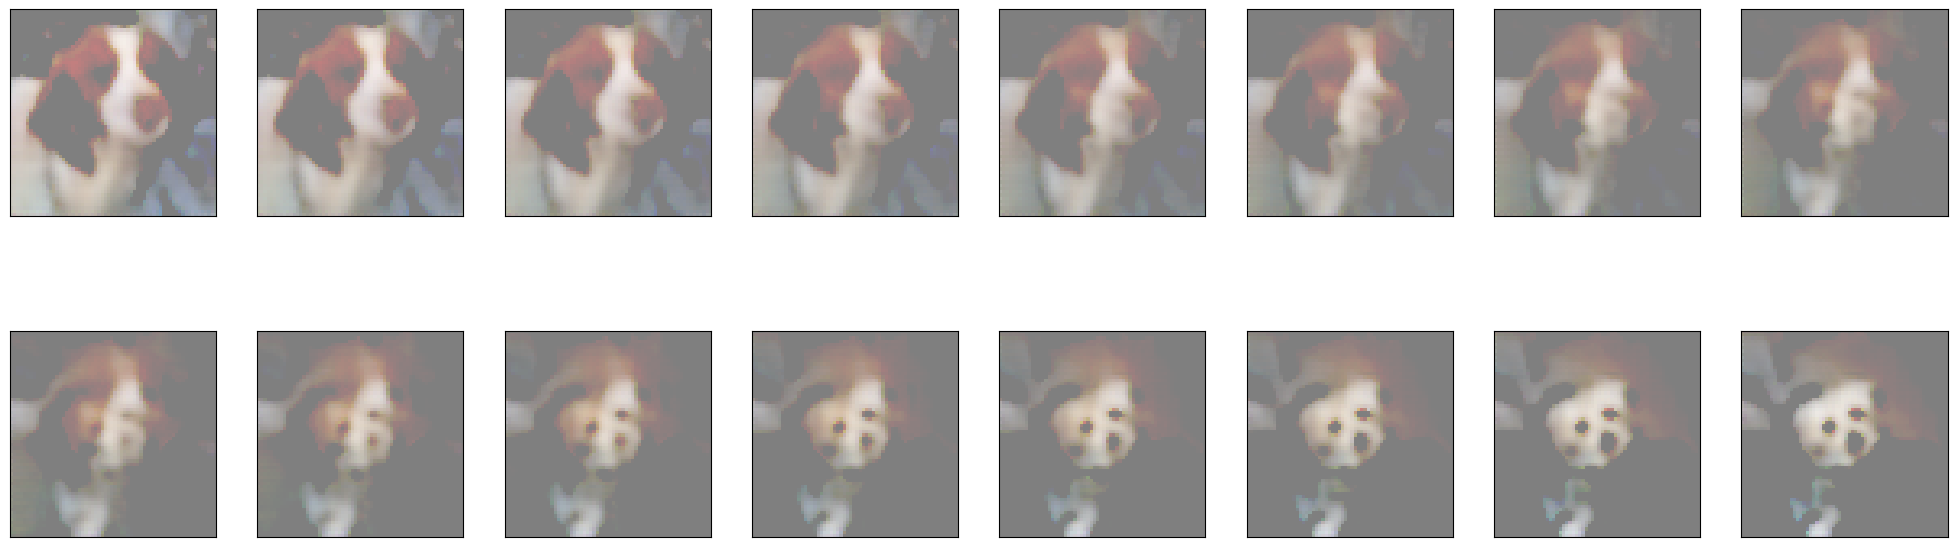

In [49]:
dog_breeds_mix(12, 14)

The mixed is done by "waliking" from the photo of one race to the other

## bonus: mixing breeds using stablediffusion 2.1

In [1]:
import logging
from pathlib import Path

import ipyplot
import matplotlib.pyplot as plt
import torch
from diffusers import StableDiffusionPipeline
from fastcore.all import concat
from huggingface_hub import notebook_login
from PIL import Image

logging.disable(logging.WARNING)

torch.manual_seed(1)
if not (Path.home()/'.huggingface'/'token').exists(): notebook_login()

In [2]:
pipe = StableDiffusionPipeline.from_pretrained("stabilityai/stable-diffusion-2-1-base", torch_dtype=torch.float16).to("cuda")

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

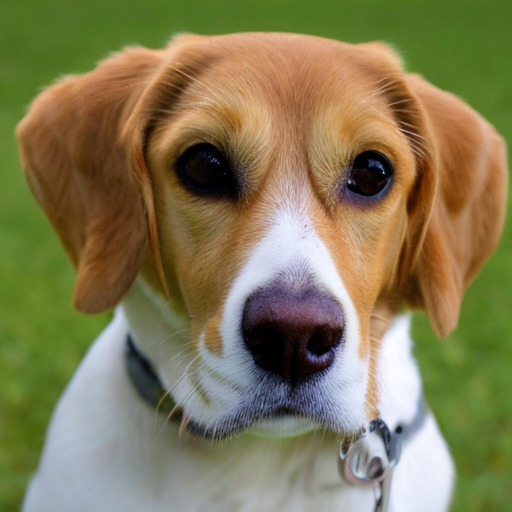

In [5]:
prompt = "beagle and golden retriever mix photo"
img = pipe(prompt).images[0]
img

  0%|          | 0/50 [00:00<?, ?it/s]

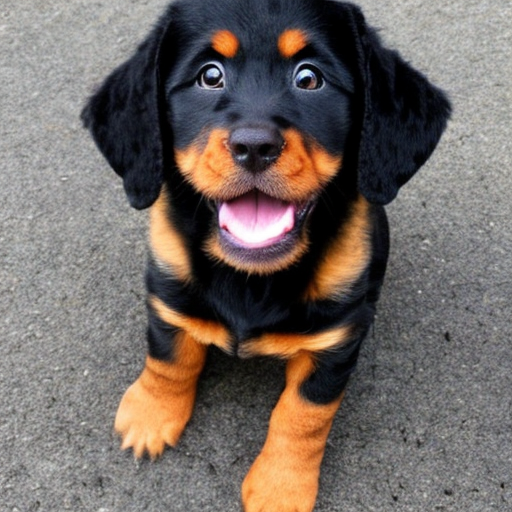

In [7]:
prompt = "rottweiler and poodle mix photo"
img = pipe(prompt).images[0]
img

In [ ]:
prompt = "rottweiler and poodle mix photo"
img = pipe(prompt).images[0]
img

  0%|          | 0/50 [00:00<?, ?it/s]

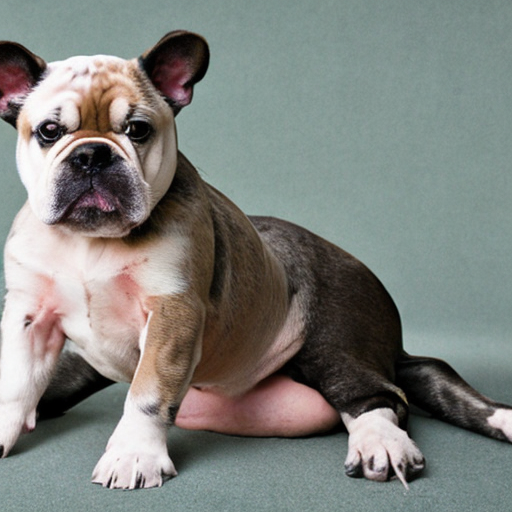

In [8]:
prompt = "bealge and bulldog mix photo"
img = pipe(prompt).images[0]
img

  0%|          | 0/50 [00:00<?, ?it/s]

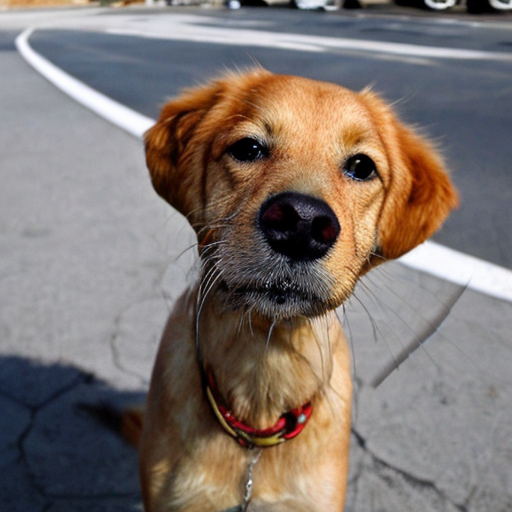

In [9]:
prompt = "caramel stray dog photo"
img = pipe(prompt).images[0]
img